<h1 align=center><font size = 5>Segmenting and Clustering Suburbs in Melbourne, Australia</font></h1>

# Introduction
In this project, we will explore, segment and cluster the suburbs in the city of Melbourne based on the postal codes and municipality information.
We will scrap the data from an existing Wikipedia page and then wrangle, clean it and then format it in a pandas DataFrame.

We will explore this dataset and cluster the suburbs together.

The goal is to find the optimal suburb to open a French restaurant.

#### Let's import the librairies we'll need for this project:

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!pip install geocoder
from geopy.geocoders import Nominatim
import geocoder # import geocoder

#!pip install folium
import folium

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!pip install streamlit
import streamlit as st
import re

# 1. Download, explore and clean dataset

#### Remark: The original page have been changed recently and we'll need to use an older version of the wikipedia page in order to get the postal codes.

In [2]:
html_data = requests.get('https://en.wikipedia.org/wiki/List_of_Melbourne_suburbs').text

#### We then parse the page using the BeautifulSoup constructor.

In [3]:
soup = BeautifulSoup(html_data, 'html5lib')

#### Once we got familiar with it, we can extract the cells and store it in a pandas DataFrame

In [4]:
suburbs=pd.DataFrame(columns=["Postal Code", "Municipality", "Suburb"])

first_link = soup.find('h3')
i = 0
sp = first_link
postal_code = ''
municipality = ''
suburb = ''

# I'm looping over the first 3 municipalities that are part of the inner city
while i <= 3:
    if sp.name == "h3":
        municipality = sp.span.a.text
        i+=1
    elif sp.name == "ul":
        for child in sp.children:
            if child.find('a') != -1:
                suburb = child.find('a').text
                postal_code = re.search(r'\d+',child.text).group(0)
                suburbs = suburbs.append({"Postal Code":postal_code, "Municipality":municipality, "Suburb":suburb}, ignore_index=True)
    sp = sp.next_sibling

In [5]:
suburbs

,Postal Code,Municipality,Suburb
0,3053,City of Melbourne,Carlton
1,3054,City of Melbourne,Carlton North
2,3008,City of Melbourne,Docklands
3,3002,City of Melbourne,East Melbourne
4,3031,City of Melbourne,Flemington
5,3031,City of Melbourne,Kensington
6,3000,City of Melbourne,Melbourne
7,3004,City of Melbourne,Melbourne
8,3051,City of Melbourne,North Melbourne
9,3052,City of Melbourne,Parkville


#### There were no suburb with the above value. We then display the shape of the df DataFrame<br>

In [6]:
suburbs.shape

(40, 3)

#### Finally we remove the duplicated suburbs

In [7]:
suburbs.groupby('Suburb').count()

,Postal Code,Municipality
Suburb,,
Abbotsford,1,1
Albert Park,1,1
Alphington,1,1
Balaclava,1,1
Burnley,1,1
Carlton,1,1
Carlton North,2,2
Clifton Hill,1,1
Collingwood,1,1


In [8]:
suburbs.drop_duplicates(subset=['Suburb'], ignore_index=True, inplace=True)

In [9]:
print(suburbs.shape)
suburbs.groupby('Suburb').count()

(34, 3)


,Postal Code,Municipality
Suburb,,
Abbotsford,1,1
Albert Park,1,1
Alphington,1,1
Balaclava,1,1
Burnley,1,1
Carlton,1,1
Carlton North,1,1
Clifton Hill,1,1
Collingwood,1,1


# 2. Getting the geographical coordinates of each postal codes

#### Running the below code to get the latitude and longitude of each postal codes and add them in new columns in the dataframe df

In [10]:
# initialize your variable to None
lat_lng_coords = None

suburbs['Latitude'] = 0
suburbs['Longitude'] = 0

for suburb in suburbs['Suburb'].unique():
    location = suburb + ', Australia'
    geolocator = Nominatim(user_agent=str(location))
    g = geolocator.geocode(location)
    suburbs.loc[suburbs['Suburb'] == suburb, 'Latitude'] = g.latitude
    suburbs.loc[suburbs['Suburb'] == suburb, 'Longitude'] = g.longitude
    
suburbs

,Postal Code,Municipality,Suburb,Latitude,Longitude
0,3053,City of Melbourne,Carlton,-37.800144,144.969268
1,3054,City of Melbourne,Carlton North,-37.784559,144.972855
2,3008,City of Melbourne,Docklands,-37.817870,144.938654
3,3002,City of Melbourne,East Melbourne,-37.815588,144.982555
4,3031,City of Melbourne,Flemington,-37.787277,144.923242
5,3031,City of Melbourne,Kensington,-33.911719,151.219506
6,3000,City of Melbourne,Melbourne,-37.814218,144.963161
7,3051,City of Melbourne,North Melbourne,-37.807609,144.942351
8,3052,City of Melbourne,Parkville,-37.787250,144.949596
9,3207,City of Melbourne,Port Melbourne,-37.833361,144.921920


# 3. Visualising the suburbs of inner Melbourne

In [11]:
print('The dataframe has {} municipalities and {} suburbs.'.format(
        len(suburbs['Municipality'].unique()),
        suburbs.shape[0]
    )
)

The dataframe has 3 municipalities and 34 suburbs.


In order to visualise, we need to first get the coordinates of Melbourne

In [12]:
address = 'Melbourne, Australia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Melbourne are -37.8142176, 144.9631608.


In [13]:
# create map of New York using latitude and longitude values
map_melbourne = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, municipality, suburb in zip(suburbs['Latitude'], suburbs['Longitude'], suburbs['Municipality'], suburbs['Suburb']):
    label = '{}, {}'.format(suburb, municipality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    
map_melbourne

# 4. Explore the suburbs in Melbourne using Foursquare

## Define Foursquare Credentials and Version

In [14]:
# @hidden_cell
CLIENT_ID = 'VBB4TRMTUFBCXARRTYNCWWOHT1ZO0M5QNCVQIYKEBJI4NKPK' # your Foursquare ID
CLIENT_SECRET = 'HQBMADDCK5D1XM3E3TKV4QC0JE1VFZ2UHUB1M4QH34BUKTIK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

## Exploring the first suburb in the municipality

In [15]:
suburbs.loc[0, 'Suburb']

'Carlton'

#### We then get the suburb latitude and longitude values

In [16]:
suburb_latitude = suburbs.loc[0, 'Latitude'] # suburb latitude value
suburb_longitude = suburbs.loc[0, 'Longitude'] # suburb longitude value

suburb_name = suburbs.loc[0, 'Suburb'] # suburb name

print('Latitude and longitude values of {} are {}, {}.'.format(suburb_name, 
                                                               suburb_latitude, 
                                                               suburb_longitude))

Latitude and longitude values of Carlton are -37.800143500000004, 144.9692678048653.


#### Similar to what we  did in the analysis with New York, we get the top 100 venues in this suburb

In [17]:
# type your answer here
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, suburb_latitude, suburb_longitude, VERSION, 500, 100)

In [18]:
results = requests.get(url).json()

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Carlton Wine Room,Wine Bar,-37.798584,144.968610
1,D.O.C. Pizza & Mozzarella Bar,Pizza Place,-37.798954,144.968490
2,Yo-Chi,Frozen Yogurt Shop,-37.798659,144.967849
3,Gewürzhaus,Gourmet Shop,-37.799050,144.967480
4,Baker D. Chirico,Bakery,-37.798788,144.968499


In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

47 venues were returned by Foursquare.


## Explore all the suburbs in the city of Melbourne municipality

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# type your answer here
melbourne_venues = getNearbyVenues(suburbs['Suburb'], suburbs['Latitude'], suburbs['Longitude'])

Carlton
Carlton North
Docklands
East Melbourne
Flemington
Kensington
Melbourne
North Melbourne
Parkville
Port Melbourne
Southbank
South Wharf
South Yarra
West Melbourne
Albert Park
Balaclava
Elwood
Middle Park
Ripponlea
St Kilda
St Kilda East
St Kilda West
South Melbourne
Abbotsford
Alphington
Burnley
Clifton Hill
Collingwood
Cremorne
Fairfield
Fitzroy
Fitzroy North
Princes Hill
Richmond


In [24]:
print(melbourne_venues.shape)
melbourne_venues.head()

(1006, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Carlton,-37.800144,144.969268,Carlton Wine Room,-37.798584,144.968610,Wine Bar
1,Carlton,-37.800144,144.969268,D.O.C. Pizza & Mozzarella Bar,-37.798954,144.968490,Pizza Place
2,Carlton,-37.800144,144.969268,Yo-Chi,-37.798659,144.967849,Frozen Yogurt Shop
3,Carlton,-37.800144,144.969268,Gewürzhaus,-37.799050,144.967480,Gourmet Shop
4,Carlton,-37.800144,144.969268,Baker D. Chirico,-37.798788,144.968499,Bakery


In [25]:
melbourne_venues.groupby('Suburb').agg({'Venue':'count'}).sort_values(by='Venue',ascending=False)

,Venue
Suburb,
Melbourne,100
Fitzroy,100
South Yarra,91
South Melbourne,60
Collingwood,57
Balaclava,53
Southbank,47
Carlton,47
Docklands,44


In [26]:
print('There are {} uniques categories.'.format(len(melbourne_venues['Venue Category'].unique())))

There are 204 uniques categories.


## Analyze each suburb

In [27]:
# one hot encoding
melbourne_onehot = pd.get_dummies(melbourne_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburb column back to dataframe
melbourne_onehot['Suburb'] = melbourne_venues['Suburb'] 

# move suburb column to the first column
melbourne_onehot = pd.concat([melbourne_onehot.loc[:, 'Suburb'], melbourne_onehot.loc[:, melbourne_onehot.columns != 'Suburb']], axis=1)

melbourne_onehot.head()

,Suburb,Adult Boutique,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Bus Stop,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comic Shop,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health Food Store,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nightclub,Office,Organic Grocery,Other Nightlife,Outlet Mall,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Road,Roof Deck,Rooftop Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Soba Restaurant,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Carlton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Carlton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Carlton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Let's examine the shape of that dataframe

In [28]:
melbourne_onehot.shape

(1006, 205)

#### Next, let's group rows by suburb and by taking the mean of the frequency of occurrence of each category

In [29]:
melbourne_grouped = melbourne_onehot.groupby('Suburb').mean().reset_index()
melbourne_grouped

,Suburb,Adult Boutique,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Bus Stop,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comic Shop,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health Food Store,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nightclub,Office,Organic Grocery,Other Nightlife,Outlet Mall,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Road,Roof Deck,Rooftop Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Soba Restaurant,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Abbotsford,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.285714,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.142857,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

#### Let's examine the shape of that dataframe

In [30]:
melbourne_grouped.shape

(33, 205)

#### Let's print each suburb along with the top 10 most common venues


In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = melbourne_grouped['Suburb']

for ind in np.arange(melbourne_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(melbourne_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbotsford,Café,Wine Shop,Italian Restaurant,Pizza Place,Park,Thai Restaurant,Zoo Exhibit,Flea Market,Fruit & Vegetable Store,Frozen Yogurt Shop
1,Albert Park,Café,Metro Station,Tennis Court,Golf Course,Seafood Restaurant,Food & Drink Shop,Athletics & Sports,Hotel,Indian Restaurant,Racetrack
2,Alphington,Liquor Store,Gym / Fitness Center,Convenience Store,Farmers Market,Fast Food Restaurant,Park,Train Station,Thai Restaurant,Flower Shop,Fruit & Vegetable Store
3,Balaclava,Café,Coffee Shop,Breakfast Spot,Bar,Pharmacy,Pizza Place,Vietnamese Restaurant,Tram Station,Salad Place,Japanese Restaurant
4,Burnley,Café,Pub,Furniture / Home Store,Breakfast Spot,Convenience Store,Park,Cocktail Bar,Shop & Service,Liquor Store,Food & Drink Shop


# 5. Cluster Suburbs

#### Finding the optimal k

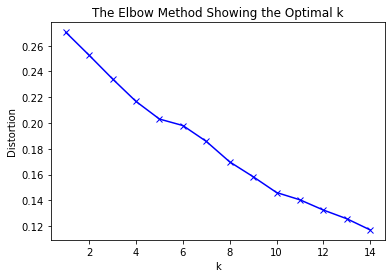

In [33]:
melbourne_venues_clustering = melbourne_grouped.drop('Suburb', 1)
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=4).fit(melbourne_venues_clustering)
    kmeanModel.fit(melbourne_venues_clustering)
    distortions.append(sum(np.min(cdist(melbourne_venues_clustering,\
                                        kmeanModel.cluster_centers_, 'euclidean'),\
                                        axis=1)) / melbourne_venues_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

#### In our case, k= 5. Let's run k-means to cluster the suburb into 5 clusters.

In [34]:
# set number of clusters
kclusters = 5

melbourne_grouped_clustering = suburbs_venues_sorted.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(melbourne_venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([3, 3, 4, 0, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3],
      dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 5 venues for each suburb.

In [35]:
suburbs_venues_sorted_withcluster = suburbs_venues_sorted.copy()
# add clustering labels
suburbs_venues_sorted_withcluster.insert(0, 'Cluster Labels', kmeans.labels_)

melbourne_merged = suburbs

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each suburb
melbourne_merged = melbourne_merged.join(suburbs_venues_sorted_withcluster.set_index('Suburb'), on='Suburb')

melbourne_merged.head() # check the last columns!

,Postal Code,Municipality,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3053,City of Melbourne,Carlton,-37.800144,144.969268,0.0,Italian Restaurant,Café,Coffee Shop,Ice Cream Shop,Gourmet Shop,French Restaurant,Indie Theater,Park,Cheese Shop,Pub
1,3054,City of Melbourne,Carlton North,-37.784559,144.972855,3.0,Café,Bakery,Tram Station,Wine Bar,Flower Shop,Pub,Deli / Bodega,Italian Restaurant,Grocery Store,Liquor Store
2,3008,City of Melbourne,Docklands,-37.817870,144.938654,0.0,Italian Restaurant,Middle Eastern Restaurant,Café,Restaurant,Pier,Chinese Restaurant,Seafood Restaurant,Steakhouse,Sandwich Place,Tapas Restaurant
3,3002,City of Melbourne,East Melbourne,-37.815588,144.982555,0.0,Café,Cricket Ground,Hotel,Restaurant,Bar,Sushi Restaurant,Museum,Stadium,Coffee Shop,Tourist Information Center
4,3031,City of Melbourne,Flemington,-37.787277,144.923242,0.0,Hotel,Racecourse,Pizza Place,Tram Station,Park,Bowling Green,Pharmacy,Supermarket,Café,French Restaurant


In [36]:
# Richmond has no venues registered in Foursquare
melbourne_merged.dropna(inplace=True)
melbourne_merged['Cluster Labels'] = melbourne_merged['Cluster Labels'].astype('int')

#### Finally, let's visualise the resulting clusters

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(melbourne_merged['Latitude'], melbourne_merged['Longitude'], melbourne_merged['Suburb'], melbourne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 5. Examine Clusters

## Cluster 1

In [38]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 0, melbourne_merged.columns[[1,2] + list(range(5, melbourne_merged.shape[1]))]]

,Municipality,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,City of Melbourne,Carlton,0,Italian Restaurant,Café,Coffee Shop,Ice Cream Shop,Gourmet Shop,French Restaurant,Indie Theater,Park,Cheese Shop,Pub
2,City of Melbourne,Docklands,0,Italian Restaurant,Middle Eastern Restaurant,Café,Restaurant,Pier,Chinese Restaurant,Seafood Restaurant,Steakhouse,Sandwich Place,Tapas Restaurant
3,City of Melbourne,East Melbourne,0,Café,Cricket Ground,Hotel,Restaurant,Bar,Sushi Restaurant,Museum,Stadium,Coffee Shop,Tourist Information Center
4,City of Melbourne,Flemington,0,Hotel,Racecourse,Pizza Place,Tram Station,Park,Bowling Green,Pharmacy,Supermarket,Café,French Restaurant
5,City of Melbourne,Kensington,0,Pizza Place,Sushi Restaurant,Chinese Restaurant,Convenience Store,Kids Store,Gym / Fitness Center,Cosmetics Shop,Malay Restaurant,Liquor Store,Burger Joint
6,City of Melbourne,Melbourne,0,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop,Shopping Mall,Clothing Store,Italian Restaurant,Cosmetics Shop,Candy Store
9,City of Melbourne,Port Melbourne,0,Climbing Gym,Café,Go Kart Track,Latin American Restaurant,Beach,Zoo Exhibit,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint
10,City of Melbourne,Southbank,0,Café,Hotel,Grocery Store,Bar,Performing Arts Venue,Italian Restaurant,Restaurant,Coffee Shop,Bakery,Australian Restaurant
11,City of Melbourne,South Wharf,0,Hotel,Bar,Clothing Store,Sporting Goods Shop,Australian Restaurant,Multiplex,Restaurant,Plaza,Seafood Restaurant,Shoe Store
12,City of Melbourne,South Yarra,0,Café,Italian Restaurant,Hotel,Japanese Restaurant,Grocery Store,Bakery,Convenience Store,Coffee Shop,Pizza Place,Dessert Shop


## Cluster 2

In [39]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 1, melbourne_merged.columns[[1,2] + list(range(5, melbourne_merged.shape[1]))]]

,Municipality,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,City of Melbourne,West Melbourne,1,Flea Market,Asian Restaurant,Farmers Market,Flower Shop,Garden,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint


## Cluster 3

In [40]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 2, melbourne_merged.columns[[1,2] + list(range(5, melbourne_merged.shape[1]))]]

,Municipality,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,City of Melbourne,Parkville,2,Zoo Exhibit,Park,Hockey Arena,Gift Shop,Food & Drink Shop,Sculpture Garden,Basketball Court,Fast Food Restaurant,BBQ Joint,Sports Club


## Cluster 4

In [41]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 3, melbourne_merged.columns[[1,2] + list(range(5, melbourne_merged.shape[1]))]]

,Municipality,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,City of Melbourne,Carlton North,3,Café,Bakery,Tram Station,Wine Bar,Flower Shop,Pub,Deli / Bodega,Italian Restaurant,Grocery Store,Liquor Store
7,City of Melbourne,North Melbourne,3,Café,Sandwich Place,Theater,Zoo Exhibit,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
14,City of Port Phillip,Albert Park,3,Café,Metro Station,Tennis Court,Golf Course,Seafood Restaurant,Food & Drink Shop,Athletics & Sports,Hotel,Indian Restaurant,Racetrack
16,City of Port Phillip,Elwood,3,Café,Indian Restaurant,Convenience Store,Bakery,Fish & Chips Shop,Bar,River,Event Space,Food & Drink Shop,Furniture / Home Store
17,City of Port Phillip,Middle Park,3,Café,Tram Station,Indian Restaurant,Food & Drink Shop,Seafood Restaurant,Metro Station,Grocery Store,Thai Restaurant,Beach,Playground
18,City of Port Phillip,Ripponlea,3,Café,Molecular Gastronomy Restaurant,Tram Station,Fish & Chips Shop,Grocery Store,Coffee Shop,Park,Train Station,Jewish Restaurant,Pharmacy
20,City of Port Phillip,St Kilda East,3,Pub,Pizza Place,Convenience Store,Café,Tram Station,Zoo Exhibit,Flea Market,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint
23,City of Yarra,Abbotsford,3,Café,Wine Shop,Italian Restaurant,Pizza Place,Park,Thai Restaurant,Zoo Exhibit,Flea Market,Fruit & Vegetable Store,Frozen Yogurt Shop
25,City of Yarra,Burnley,3,Café,Pub,Furniture / Home Store,Breakfast Spot,Convenience Store,Park,Cocktail Bar,Shop & Service,Liquor Store,Food & Drink Shop
26,City of Yarra,Clifton Hill,3,Café,Pizza Place,Seafood Restaurant,Park,Convenience Store,Bakery,Stadium,Garden,Flower Shop,Gastropub


## Cluster 5

In [42]:
melbourne_merged.loc[melbourne_merged['Cluster Labels'] == 4, melbourne_merged.columns[[1,2] + list(range(5, melbourne_merged.shape[1]))]]

,Municipality,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,City of Yarra,Alphington,4,Liquor Store,Gym / Fitness Center,Convenience Store,Farmers Market,Fast Food Restaurant,Park,Train Station,Thai Restaurant,Flower Shop,Fruit & Vegetable Store


# Conclusion

#### According to the Foursquare data, the most popular suburbs are Melbourne, Fitzroy and South Yarra with a number of venue superior or around 100. They are all part of Cluster one where the most popular venues are bar, restaurants and cafe. They seem to be the ideal place to open a restaurant.